# Image to Point Cloud Diffusion

This notebook demonstrates how to use the attention analysis tools when diffusing a point cloud from an input image, and produces plots of the associated attention maps used for downstream analysis.

In [1]:
# Standard imports
import seaborn as sns
import matplotlib.pyplot as plt
import imageio, importlib
from PIL import Image
from IPython.display import HTML

import numpy as np
import nopdb
import math, torch
from tqdm.auto import tqdm

import sys

# Detect local paths
local_path = !pwd
local_path = local_path[0][:-5]
sys.path.append(local_path + 'src/')

# Import modules from point_e
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.plotting import plot_attention_cloud

# Import modules from attention analysis 
from scripts.attention_analysis import AttentionTools

breakpoints = [0, 10, 20, 30, 40, 50, 60, 64, 120]
time = [0, 1, 2, 3, 4, 5, 6, 7, 8]
frames = []

Text(0.5, 1.0, 'Input Image\n')

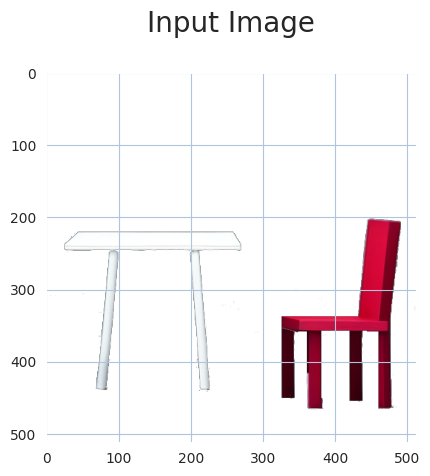

In [2]:
# Load an image to condition on.
img = Image.open(local_path + 'src/imgs/example_data/chair_trans_3.png')

plt.imshow(img)
plt.title('Input Image\n', size = 20)

### 0. Import point-cloud-diffusion models from point-e

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


### 2. Attention Analysis

Sample attention maps extracted during diffusion processes

In [4]:
Attention = AttentionTools(base_model, sampler)

In [5]:
self_attn, cross_attn, avg_attn, samples = Attention.sample_from_model(img)

0it [00:00, ?it/s]

In [6]:
%%capture
Attention.attention_pointcloud(samples, self_attn, upsample = True)

In [7]:
HTML('<img src="../src/imgs/results/PC_diffusion/Attention_cloud.gif">')

# 2. Attention Map Evaluations

## 2.1 Heatmaps

## 2.1.1 2-Dimensions


In [8]:
%%capture
Attention.heatmap2d(self_attn, cross_attn, avg_attn)

In [9]:
HTML('<img src="../src/imgs/results/Heatmaps_2D/Full_attention/full_2d_attention.gif">')

#### Closer insepctions
Look at heatmap in spesific index ranges

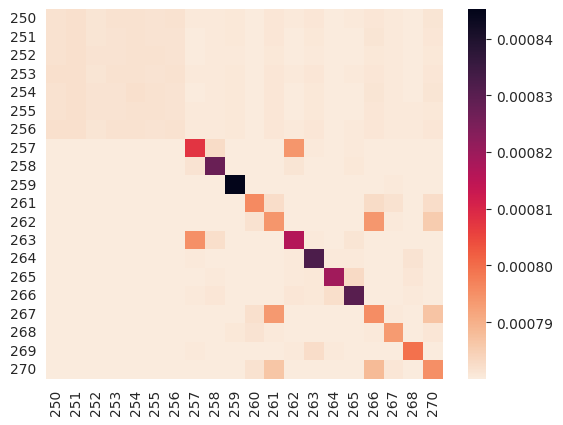

In [10]:
Attention.heatmap2d_inspection(avg_attn[-1], i = 250, j = 270)

### 2.1.2 3D Attention maps

In [ ]:
%%capture
Attention.heatmap3d(samples, self_attn)

In [ ]:
HTML('<img src="../src/imgs/results/Heatmaps_3D/attention_idx.gif">')

## 2.2 Spectra plots

Plot spectra of attention in index i from all components j

In [ ]:
%%capture
Attention.spectra_plots(self_attn)

In [2]:
HTML('<img src="../src/imgs/results/Heatmaps_3D/attention_idx.gif">')

## 2.3 Code to plot colored attention clouds 

In [ ]:
%%capture
Attention.attention_pointcloud(samples, self_attn, attn_vals = True)

## 2.4 Point Tracker


In [ ]:
%%capture
Attention.attention_pointcloud(samples, self_attn, point_tracker = True)

## 2.5 Max attention

In [ ]:
%%capture
Attention.attention_pointcloud(samples, self_attn, max_attention = True)